In [21]:
import yaml
import numpy as np
import obspy
from obspy import UTCDateTime
from obspy import Trace
from obspy.clients.fdsn import Client
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec #for organizing subplots
from tqdm import trange
                        # t = trange(len(waveforms), desc="Trimming Waveforms ", leave=True)
                        #    for i in t:
import h5py
# %matplotlib inline
import sys
sys.path.append("/data/wsd01/pnwstore/")
import eqcorrscan
from eqcorrscan.core.match_filter import match_filter
from eqcorrscan.core.match_filter.tribe import Tribe
import pandas as pd

from time import time

from pnwstore.mseed import WaveformClient
from obspy.core.utcdatetime import UTCDateTime

client = WaveformClient()
client2 = Client('IRIS')

In [2]:
with open('/home/smocz/expand_redpy/scripts/config.yaml') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

fs = config['fs']
tb = config['tb']
ta = config['ta']
fqmin = config['fqmin']
fqmax = config['fqmax']
nbucket = config['nbucket']
chan = config['chan']
homedir = config['homedir']
readdir = config['readdir']
f_o = config['f_o']
p_len = config['p_len']

vv = config['vv']

snr_t = config['snr_t']
thr_on = config['thr_on']
thr_off = config['thr_off']
nsta = config['nsta']
nlta = config['nlta']
pr = config['pr']

print(vv)

1


In [3]:
Baker = pd.read_csv(readdir+'Baker_catalog.csv')
Hood = pd.read_csv(readdir+'Hood_catalog.csv')


St_Helens = pd.read_csv(readdir+'MountStHelens_catalog.csv')

# Combining borehole and local catalogs with St_Helens

Helens_Borehole = pd.read_csv(readdir+'MSHborehole_catalog.csv')
Helens_Borehole['Clustered'] += 2000 
# Cluster 0 in Helens_Borehole is now Cluster 2000 in St_Helens
Helens_Local = pd.read_csv(readdir+'MSHlocal_catalog.csv')
Helens_Local['Clustered'] += 3000
# Cluster 0 in Helens_Local is now Cluster 3000 in St_Helens

# Use St_Helens to access all three St Helens catalogs
St_Helens = pd.concat([St_Helens,Helens_Borehole,Helens_Local])

Newberry = pd.read_csv(readdir+'Newberry_catalog.csv')
Rainier = pd.read_csv(readdir+'Rainier_catalog.csv')

volc_md = pd.read_csv(readdir+'Volcano_Metadata.csv')
# read metadata file to create dataframe of labels

In [4]:
volc_md['netsta'] = volc_md['Network'].astype(str)+'.'+volc_md['Station'].astype(str)
Baker_sta = volc_md[volc_md['Volcano_Name'] == 'Baker']['netsta'].values.tolist()
Hood_sta = volc_md[volc_md['Volcano_Name'] == 'Hood']['netsta'].values.tolist() 
St_Helens_sta = volc_md[volc_md['Volcano_Name'] == 'St_Helens']['netsta'].values.tolist()
Newberry_sta = volc_md[volc_md['Volcano_Name'] == 'Newberry']['netsta'].values.tolist() 
Rainier_sta = volc_md[volc_md['Volcano_Name'] == 'Rainier']['netsta'].values.tolist()

In [5]:
volc_list = [Baker,Hood,Newberry,Rainier,St_Helens] # list of dataframes for each volcano
volc_list_names = ['Baker','Hood','Newberry','Rainier','St_Helens'] # list of names of each volcano
volc_sta = [Baker_sta,Hood_sta,Newberry_sta,Rainier_sta,St_Helens_sta] # lists of stations connected to respective volcanoes

------------
Cluster ID: 0 Volcano: Hood Station: BRSP Network: CC
0 Trace(s) in Stream:

shift complete

sst not long enough
0.012822151184082031 seconds to attempt to find 5 waveforms
------------
Cluster ID: 1 Volcano: Hood Station: BRSP Network: CC
0 Trace(s) in Stream:

shift complete

sst not long enough
0.03470420837402344 seconds to attempt to find 14 waveforms
------------
Cluster ID: 2 Volcano: Hood Station: BRSP Network: CC
2020-12-13T13:30:09.800000
3521
2020-12-15T02:56:07.040000
3521
2 Trace(s) in Stream:
CC.BRSP..BHZ | 2020-12-13T13:29:51.800000Z - 2020-12-13T13:31:19.800000Z | 40.0 Hz, 3521 samples
CC.BRSP..BHZ | 2020-12-15T02:55:49.050000Z - 2020-12-15T02:57:17.050000Z | 40.0 Hz, 3521 samples
Working on shifting
before alignment: 0 1.0
after alignment 0 1.0
Working on shifting
before alignment: -1 0.486838963
after alignment 0 0.486841502
shift complete

length of sst: 2


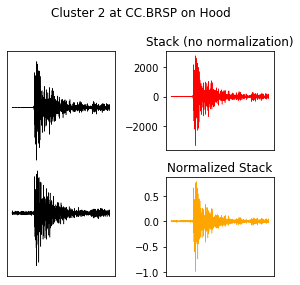

In [33]:
# for vv,v in enumerate(volc_sta): #vv is the number in the list, v is the station list for current volcano
v = volc_sta[vv]
clid = volc_list[vv]['Clustered'].values.tolist() #find the largest cluster ID for a volcano to set range
for s in range(0,len(v)): #loop through stations
    net, sta =  v[s].split('.') #add specific network per station
    t0 = time() #record time
    cid = [] #cid will become a list of cluster IDs that have templates
    st3=obspy.Stream() #st3 will become a stream of traces, each trace being the template/stack for a cluster

    for cl in range(0,(clid[-1]+1)): #cl is cluster ID
    # clid[-1] is the highest cluster ID, and add 1 so that the last cluster id is not skipped
        t2=time()
        sst=obspy.Stream() #sst will have every trace for each cluster
        print('------------') #divider for clarity
        print('Cluster ID: '+str(cl)+' Volcano: '+volc_list_names[vv]+' Station: '+sta+' Network: '+net) #keeping track of what is currently running
        date_list = volc_list[vv][volc_list[vv]['Clustered'] == cl]['datetime'].values.tolist()
        for ii,i in enumerate(date_list): #i is each datetime from cl at this volcano
            stt=UTCDateTime(i)-tb-nlta #starttime
            et=UTCDateTime(i)+ta #endtime
            utct=UTCDateTime(i) #datetime from REDpy catalog
            
            sta_st = UTCDateTime(volc_md[volc_md['netsta']==v[s]]['Starttime'].values[0])
            sta_nd = UTCDateTime(volc_md[volc_md['netsta']==v[s]]['Endtime'].values[0])
            
            if UTCDateTime(i)<sta_st or UTCDateTime(i)>sta_nd:
#                 print(f'{i} before sta start {sta_st} or after sta end {sta_nd}')
                continue
            
            print(i)
            
            ### PULL WAVEFORM ###
            
            st = client.get_waveforms(network=net,station=sta,location='*',
                                      channel=chan, year=utct.year, doy=utct.julday)
            st = st.detrend(type = 'demean')
            st.filter(type='bandpass',freqmin=fqmin,freqmax=fqmax)
            st.resample(fs) #get same sampling rate for all events
            st.trim(starttime=stt,endtime=et)
            st.merge(fill_value = 0)

            ### CHECK DATA ###
            
            if len(st)==0:
                print('no data for this time')
                continue
            print(len(st[0].data))
            if len(st[0].data) == round((ta+tb+nlta)*fs)+1: #if there is enough data to contribute to making a stack
                sst.append(st[0])
    #         break
    
        ### SHIFT TRACES IN CL ###
    
        print(sst) #see how many traces were found
        st2=sst.copy() #copy of sst after appending is finished/all waveforms for a cluster are gathered, reference for shifting
        st4=st2.copy() #st4 will become the aligned version of st2
        for i in range(0, len(st2)):
            print('Working on shifting') # Will not print if len(st2)==0
            # Also serves as a divider between shift and cc values for different waveforms
            xcor = obspy.signal.cross_correlation.correlate(st2[i].data[:],sst[0].data[:],200)
            index = np.argmax(xcor)
            cc = round(xcor[index],9)
            shift = 200-index
            print('before alignment:',shift,cc) #the shift and cross correlation values before shifting/alignment. Perfect shift is 0, perfect cross correlation is 1
            if shift<0: st4[i].data[:shift]=st2[i].data[-shift:]
            if shift>0: st4[i].data[shift:]=st2[i].data[:-shift]
            xcor = obspy.signal.cross_correlation.correlate(st4[i].data[:],sst[0].data[:],200)
            index = np.argmax(xcor)
            cc = round(xcor[index],9)
            shift = 200-index
            print('after alignment',shift,cc) #shift and cross correlation values after alignment. shift should be 0
        print('shift complete')
        print( )
        
        
        sst2=st4.copy() #sst2 is a copy of st4 once alignment is finished
        sst3=st4.copy() #another copy for normalization
        sst2.stack() #stack aligned waveforms
        
        sst3 = sst3.normalize()
        sst3.stack()
        
        if len(sst)<2: #some clusters will have 1 or 0 traces due to unavailable data
            print('sst not long enough')
            t4=time()
            print(f'{str(t4-t2)} seconds to attempt to find {len(date_list)} waveforms')
            continue

        print('length of sst: '+str(len(sst))) #should be 2 or higher
        st3.append(sst2[0])

        cid.append('rp'+volc_list_names[vv][:2].lower()+str(cl).zfill(len(str(clid[-1])))) #append the clusterID to cid. rp for REDpy, volc_list_names[vv][:2].lower() for the volcano name
        # writing seisbench h5py

        lat = volc_md[volc_md['netsta']==v[s]]['Latitude'].values[0]
        lon = volc_md[volc_md['netsta']==v[s]]['Longitude'].values[0]
        
        ### PLOTTING ###
        
        ncols = 2
        if len(sst) <=4:
            nrows = len(sst)
        else:
            nrows = math.ciel(len(sst)/2)
        
        fig, ax0 = plt.subplots(figsize=(len(sst)*2,4))
        gs = GridSpec(len(sst), 2, figure=fig) #make GridSpec for formatting subplots, based on number of waveforms
        ax1 = fig.add_subplot(gs[0:len(sst),0:1])
        ax2 = fig.add_subplot(gs[0:1,1:2])
        ax3 = fig.add_subplot(gs[1:2,1:2])
        
        yscale = 2 #how far to space waveforms from eachother
        wavecolor = 'black'
        for ww, wave in enumerate(sst):
            ax1.plot(wave.data[:]/np.max(np.abs(wave.data))+yscale+(yscale*ww),color=wavecolor,linewidth=.5)
        ax1.tick_params(axis='both', which='both', bottom=False,left=False,labelbottom=False,labelleft=False)

            
        #plot un-normalized stack
        ax2.plot(sst2[0].data[:],color='red',linewidth=.5)
        ax2.set_title('Stack (no normalization)')
        ax2.tick_params(axis='x', which='both', bottom=False,labelbottom=False)

        
        #plot normalized stack
        ax3.plot(sst3[0].data[:],color='orange',linewidth=.5)
        ax3.set_title('Normalized Stack')
        ax3.tick_params(axis='x', which='both', bottom=False,labelbottom=False)
        
        fig.suptitle(f'Cluster {cl} at {v[s]} on {volc_list_names[vv]}')
        fig.set_tight_layout(True)
        fig.delaxes(ax0) #remove unused ax
        
#         fig.savefig() #save to its own folder, as svg if there's enough room
        
        break
    break


In [ ]:
       # fill in metadata 
#         meta = meta.append({"source_id": cid[-1], "source_origin_time": '', 
#             "source_latitude_deg": "%.3f" % 0, "source_longitude_deg": "%.3f" % 0, 
#             "source_type": 'unknown',
#             "source_depth_km": "%.3f" % 0, "source_magnitude": 0,
#             "station_network_code": net, "trace_channel": sst[0].stats.channel, 
#             "station_code": sta, "station_location_code": sst[0].stats.location,
#             "station_latitude_deg": lat,  "station_longitude_deg": lon,
#             "station_elevation_m": 0,
#             "trace_p_arrival_sample": 0, "CODE": sta.lower()+'bhz'+cid[-1]}, ignore_index = True)

#         # fill in data
#         ibucket = np.random.choice(list(np.arange(nbucket) + 1))
#         data = update_data(data, st3[-1], ibucket)
#         print('ibucket: ',ibucket,data[ibucket])
#         t3=time()
#         print(str(t3-t2)+' seconds to make the stack for this cluster')
# # BREAK FOR THE CLUSTER LOOP
# #         break
#     t1=time()
#     print(str(t1-t0)+'seconds to make stacks for one station for all clusters with enough data')
    
#     # integrate tribe
#     stack_list = [] #will be a list of streams,each stream has one stack as a trace
#     for i in range(0,len(st3)):
#         temp = obspy.Stream(st3[i]) #give each trace in st3 its own stream
#         stack_list.append(temp) #append each stream to stack_list
#         print('appending stack list')
#     print(stack_list)

#     print('got stack list!')

#     #filter for snr with temp list, remember to keep cid in order
#     cidu = [] #updated cid
#     temp_list = []
#     for ll,l in enumerate(stack_list):
#         cft = classic_sta_lta(l[0].data, int(nsta * fs), int(nlta * fs)) #basis for stalta
#         print('-------------')
#         print(l[0].stats.starttime+nlta)
#         plot_trigger(l[0], cft, thr_on, thr_off) #print stalta plots
#         print('C ID:', cid[ll])
#         on_off = np.array(trigger_onset(cft, thr_on, thr_off)) #x value of vlines in the plot (plot_trigger is NOT needed for this to work)
#         if not np.any(on_off):
#             print('NO SIGNAL FOUND')
#             continue
#         index = []
#         for ii,i in enumerate(on_off): #for each signal detection in on_off
#         #     print(i)
#             if i[1]-i[0] == 0: #if the start and end times are same, mark
#                 index.append(ii)
#         on_off = np.delete(on_off,index, axis=0) #remove marked signal windows by index
#         print('on_off')
#         print(on_off)
#         amps = []
#         for ii,i in enumerate(on_off): #go through each possible signal window
#             start = i[0]
#             end = i[1]
#             amps.append(Trace(data=l[0].data[start:end]).max()) #find max amplitude in that signal window
#         # print(amps)
#         amp = max(amps, key=abs) #find max amplitude of stream within sta/lta windows
#         # print(amp)
#         for ii,i in enumerate(on_off): #go through each possible signal window
#             start = i[0]
#             end = i[1]
#             ooamp = Trace(data=l[0].data[start:end]).max() #find max amplitude in that signal window
#             print('amp',amp,'ooamp',ooamp,'start',start,'end',end)
#             if amp == ooamp: #if max amplitude of this window is the same as the overall max amplitude
#                 print('wow')
#                 trig_on = round(float(start / fs),4) #took out -nlta
#                 trig_off = round(float(end / fs),4) #get start and end times
#                 break #move on
#         # show trigger on and off times, rounded to 4 decimal places
#         print('Trigger on',trig_on-nlta,'seconds after tb time') #trig_on-nlta is picktime...?
#         print('Trigger off',trig_off-nlta,'seconds after tb time')

#         signal_window = l[0].copy()
#         noise_window = l[0].copy()

#         signal_window.trim(starttime=l[0].stats.starttime+trig_on,endtime=l[0].stats.starttime+trig_off)
#         #i+trig_on-0.5 to include lead up to the signal
#         noise_window.trim(starttime=l[0].stats.starttime,endtime=l[0].stats.starttime+nlta)

#         snr = 20 * np.log(np.percentile(np.abs(signal_window.data),pr) 
#                           / np.percentile(np.abs(noise_window.data),pr))/np.log(10)
#         print('snr:',snr)
#         if snr>=snr_t: #if SNR is greater than or equal to minimum, save it
#             l.trim(starttime=l[0].stats.starttime+nlta,endtime=l[0].stats.endtime)
#             cidu.append(cid[ll])
#             temp_list.append(l)
    

#     template_stream = [] #will be a list of streams that have been filtered to become templates
#     for i in range(0,len(temp_list)):
#         template_stream.append(eqcorrscan.core.match_filter.template.Template(
#             name=sta.lower()+temp_list[i][0].stats.channel.lower()+cidu[i],st=temp_list[i], \
#                 lowcut=fqmin, highcut=fqmax, samp_rate=fs, filt_order=f_o, process_length=p_len))
#         #filter each stream from temp_list and append to template_stream
#         print('appending template stream')
#     print('made template stream!')

#     tribe = eqcorrscan.core.match_filter.tribe.Tribe(templates = template_stream)
    #make a tribe from template_stream, each template will be made from a stream in template_stream
#     print('making tribe...')

#     if len(st3) > 0:
#         print('Writing tribe in progress...')
#         tribe.write(homedir+'/templates/Volcano_' + volc_list_names[vv] + '_Network_' + \
#                     net + '_Station_' + sta + '_Channel_' + st3[0].stats.channel)
# #         print('Wrote tribe sucessfully!')
#         # add to file
#         meta.to_csv("/data/whd02/Data_rp/metadata_"+volc_list_names[vv]+"_"+net+"_"+sta+".csv",sep = ',', index=False)
#         f = h5py.File("/data/whd02/Data_rp/waveforms_"+volc_list_names[vv]+"_"+net+"_"+sta+".hdf5",'a') #appending mode
#             #If the file does not exist, it creates a new file for writing.
#         # need to define f in order to close it in order to open it in mode w
#         if f: f.close()
#         f = h5py.File("/data/whd02/Data_rp/waveforms_"+volc_list_names[vv]+"_"+net+"_"+sta+".hdf5",'w') #writing mode
# #         f['/data_format/component_order'] ='ZNE'
#         print(range(nbucket))
#         for b in range(nbucket):
#             f['/data/bucket%d' % (b + 1)] = data[b + 1]
#         f.close()

#         print('Saved!')
# BREAK FOR THE STATION LOOP
#     break
# BREAK FOR THE VOLCANO LOOP
#     break